In [20]:
import pandas as pd
import decimal as dc
import numpy as np
%matplotlib inline
"""
处理中烟实际运行线路数据
"""
dc.getcontext().rounding = dc.ROUND_HALF_UP
matrix_id = pd.read_csv("data/mapping", names=['id', 'lat', 'lng'], dtype={'id': int, 'lat': str, 'lng':str})
# matrix_id[['lng', 'lat']] = matrix_id[['lng', 'lat']].astype(str)
# print(matrix_id)
matrix_id = matrix_id.set_index(['lng', 'lat'])
print(matrix_id['id'])

matrix = pd.read_csv("data/matrix", names=['order', 'from_id', 'to_id', 'distance', 'time']).set_index(['from_id', 'to_id'])
# print(matrix['to_id'])

# distance, time = matrix.loc[9723, 9722][['distance', 'time']]

data = pd.read_excel("data/zhongyan_current_res.xlsx")
data.drop(['装货体积（方）', '要求装货时间', '要求送达时间'],axis=1, inplace=True)
data.rename(columns=
    {'订单ID':'orderId',
    '经度':'lng',
    '纬度':'lat',
    '送货路线':'route',
    '装货重量（吨）':'weight'}, inplace=True)
# print(data.count())

depot_lng = '117.273733'
depot_lat = '31.787423'
depot_id = matrix_id.loc[depot_lng, depot_lat]['id']

statistic = {}
for name, group in data.groupby('route'):
    last_id = depot_id
    route_transport_time = 0
    route_distance = 0
    
    for i in range(len(group) - 1):
        cur_lng = str(group.iloc[i]['lng'])
        cur_lat = str(group.iloc[i]['lat'])
        cur_id = matrix_id.loc[cur_lng, cur_lat]['id']

        res = (0, 0)
        if(last_id != cur_id):
            try:
                res = matrix.loc[last_id, cur_id][['time', 'distance']]
            except KeyError:
                res = matrix.loc[cur_id, last_id][['time', 'distance']]
#         print(res)
        route_transport_time += res[0]
        # 卸货时间，单位秒
        route_transport_time += 180
        route_distance += res[1]
        last_id = cur_id
    ## 回仓
    res = (0, 0)
    if(last_id != depot_id):
        try:
            res = matrix.loc[last_id, depot_id][['time', 'distance']]
        except KeyError:
            res = matrix.loc[depot_id, last_id][['time', 'distance']]
    route_transport_time += res[0]
    route_distance += res[1]
    statistic[name] = {'time': dc.Decimal(route_transport_time / 60, dc.getcontext()).__round__(0),
                       'distance': dc.Decimal(route_distance / 1000, dc.getcontext()).__round__(0)}
    
current_res = pd.DataFrame(statistic)
# current_res['总计'] = current_res.sum(axis=1)
current_res



lng         lat      
117.273733  31.787423    9724
117.424     32.14939     9723
117.60194   32.14232     9722
117.4487    32.12726     9721
117.5305    32.12416     9720
117.8037    32.19558     9719
117.56023   32.00885     9718
117.8228    32.14601     9717
117.5449    32.05714     9716
117.55934   32.008198    9715
117.55972   32.006813    9714
117.5862    32.08328     9713
117.6099    32.15253     9712
117.634735  32.021877    9711
117.3837    32.08095     9710
117.3962    32.12677     9709
117.660805  32.211815    9708
117.64166   32.173355    9707
117.5287    32.19047     9706
117.4286    32.14827     9705
117.5243    32.190697    9704
117.4254    32.146378    9703
117.4819    31.949       9702
117.60929   32.163322    9701
117.38318   32.078606    9700
117.48136   31.94685     9699
117.45801   32.200867    9698
117.6678    32.02503     9697
117.66507   32.027084    9696
117.7414    32.07996     9695
                         ... 
117.57341   32.001377    9110
117.45158   32.092

,线路01,线路02,线路03,线路04,线路05,线路06,线路07,线路08,线路09,线路10,线路11,线路12,线路13,线路14,线路15
distance,282,365,230,209,276,257,307,210,328,232,425,181,216,239,213
time,715,843,626,555,683,663,742,540,862,647,1013,508,613,650,627


In [249]:

"""
统计Jsprit输出方案(时间均衡版）的距离与时间
"""
def transform(timeStr):
    return int(timeStr.split(":")[0]) * 60 + int(timeStr.split(":")[1]) - 8 * 60

data = pd.read_excel("data/zhongyan_balanced_res.xls", header=None, names=['route', 'vehicleType', 'type', 'orderId', 'arrTime', 'endTime', 'distance', 'cost'])
data.dropna(axis=0, how='all', inplace=True)
data = data.groupby('route')

statistic = {}
for name, group in data:
    statistic["路线%.2d" % name] = {"distance": group.iloc[-1]['distance'] / 1000, "time": transform(group.iloc[-1]['endTime'])}
    
balanced_res = pd.DataFrame(statistic)
# balanced_res['总计'] = balanced_res.sum(axis=1)
balanced_res



,路线01,路线02,路线03,路线04,路线05,路线06,路线07,路线08,路线09,路线10,路线11,路线12,路线13,路线14,路线15
distance,247.169,278.282,194.78,271.758,260.282,228.51,243.45,242.857,230.001,245.583,239.531,233.576,231.985,233.464,252.601
time,630.000,630.000,615.00,630.000,627.000,630.00,630.00,629.000,621.000,629.000,629.000,629.000,630.000,624.000,626.000


In [250]:
"""
统计Jsprit输出方案(总成本最小版）的距离与时间
"""
def transform(timeStr):
    return int(timeStr.split(":")[0]) * 60 + int(timeStr.split(":")[1]) - 8 * 60

data = pd.read_excel("data/zhongyan_min_cost_res.xls", header=None, names=['route', 'vehicleType', 'type', 'orderId', 'arrTime', 'endTime', 'distance', 'cost'])

data.dropna(axis=0, how='all', inplace=True)

data = data.groupby('route')

statistic = {}
for name, group in data:
    statistic["路线%.2d" % name] = {"distance": group.iloc[-1]['distance'], "time": transform(group.iloc[-1]['endTime'])}
    
min_cost_res = pd.DataFrame(statistic)
# min_cost_res['总计'] = min_cost_res.sum(axis=1)
min_cost_res

,路线01,路线02,路线03,路线04,路线05,路线06,路线07,路线08,路线09,路线10,路线11,路线12,路线13,路线14
distance,183.0,176.0,169.0,192.0,192.0,163.0,167.0,170.0,208.0,161.0,159.0,135.0,130.0,154.0
time,630.0,630.0,543.0,630.0,629.0,573.0,579.0,623.0,624.0,606.0,530.0,366.0,464.0,385.0


505
[0.08535044230582288, 0.24059492563429571]


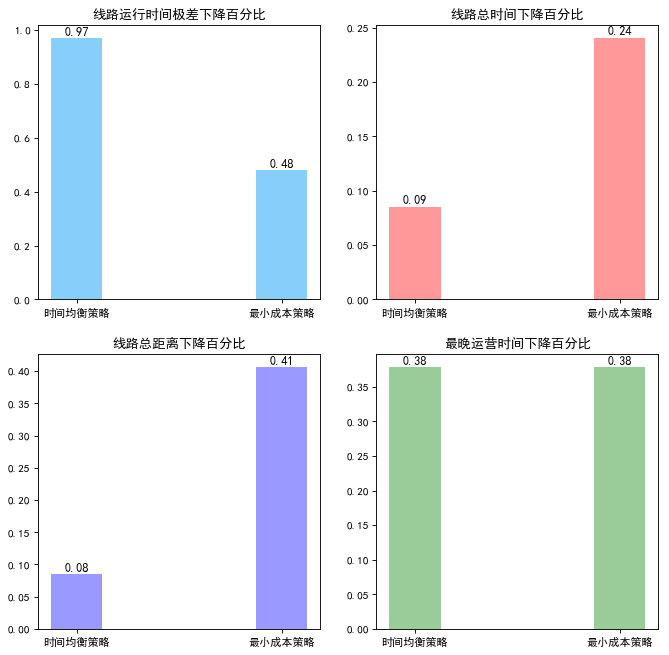

In [316]:
"""
统计图
"""
import matplotlib.pyplot as plt
import numpy as np

figure_1 = plt.figure(figsize=(10,10), dpi=80)
opacity = 0.4

# 运行时间极差下降百分比
current_time_range = current_res.loc['time'].max() - current_res.loc['time'].min()
print(current_time_range)
balance_time_range_improved =(current_time_range - dc.Decimal(balanced_res.loc['time'].max() - balanced_res.loc['time'].min())) \
    / current_time_range
minCost_time_range_improved = (current_time_range - dc.Decimal(min_cost_res.loc['time'].max() - min_cost_res.loc['time'].min())) \
    / current_time_range
    
# 最晚运营时间下降百分比
current_max_time = float(current_res.loc['time'].max())
balance_max_time_improved = (current_max_time - balanced_res.loc['time'].max()) / current_max_time
minCost_max_time_improved = (current_max_time - min_cost_res.loc['time'].max()) / current_max_time

# 总运行时间下降百分比
current_total_time  = float(current_res.loc['time'].sum())
balanced_total_time_improved = (current_total_time - balanced_res.loc['time'].sum()) / current_total_time
minCost_total_time_improved = (current_total_time - min_cost_res.loc['time'].sum()) / current_total_time
    
# 总距离下降百分比
current_total_distance = float(current_res.loc['distance'].sum())
balanced_total_distance_improved = (current_total_distance - balanced_res.loc['distance'].sum()) / current_total_distance
minCost_total_distance_improved = (current_total_distance - min_cost_res.loc['distance'].sum()) / current_total_distance
    
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

plt.subplot(2,2,1)
range_list = [float(balance_time_range_improved.__round__(2)), float(minCost_time_range_improved.__round__(2))]
plt.bar(np.arange(2), range_list, 0.25,color="#87CEFA", tick_label=['时间均衡策略', '最小成本策略'])
for a,b in zip(np.arange(2), range_list):
    plt.text(a, b+0.001, '%.2f' % b, ha='center', va= 'bottom',fontsize=11)
plt.title(u"线路运行时间极差下降百分比")

plt.subplot(2,2,2)
totalTime_list = [balanced_total_time_improved, minCost_total_time_improved]
print(totalTime_list)
plt.bar(np.arange(2), totalTime_list, 0.25,alpha=opacity, color="red", tick_label=['时间均衡策略', '最小成本策略'])
for a,b in zip(np.arange(2), totalTime_list):
    plt.text(a, b+0.001, '%.2f' % b, ha='center', va= 'bottom',fontsize=11)
plt.title("线路总时间下降百分比")

plt.subplot(223)
totalDistance_list = [balanced_total_distance_improved, minCost_total_distance_improved]
plt.bar(np.arange(2), totalDistance_list, 0.25, alpha=opacity, color='b', tick_label=['时间均衡策略', '最小成本策略'])
for a,b in zip(np.arange(2), totalDistance_list):
    plt.text(a, b+0.001, '%.2f' % b, ha='center', va= 'bottom',fontsize=11)
plt.title("线路总距离下降百分比")

plt.subplot(224)
totalMaxtime_list = [balance_max_time_improved, minCost_max_time_improved]
plt.bar(np.arange(2), totalMaxtime_list, 0.25, alpha=opacity, color='green', tick_label=['时间均衡策略', '最小成本策略'])
for a, b in zip(np.arange(2), totalMaxtime_list):
    plt.text(a, b+0.001, '%.2f' % b, ha='center', va='bottom', fontsize=11)
plt.title("最晚运营时间下降百分比")

In [19]:
matrix.index

MultiIndex(levels=[[9082, 9083, 9084, 9085, 9086, 9087, 9088, 9089, 9090, 9091, 9092, 9093, 9094, 9095, 9096, 9097, 9098, 9099, 9100, 9101, 9102, 9103, 9104, 9105, 9106, 9107, 9108, 9109, 9110, 9111, 9112, 9113, 9114, 9115, 9116, 9117, 9118, 9119, 9120, 9121, 9122, 9123, 9124, 9125, 9126, 9127, 9128, 9129, 9130, 9131, 9132, 9133, 9134, 9135, 9136, 9137, 9138, 9139, 9140, 9141, 9142, 9143, 9144, 9145, 9146, 9147, 9148, 9149, 9150, 9151, 9152, 9153, 9154, 9155, 9156, 9157, 9158, 9159, 9160, 9161, 9162, 9163, 9164, 9165, 9166, 9167, 9168, 9169, 9170, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182, 9183, 9184, 9185, 9186, 9187, 9188, 9189, 9190, 9191, 9192, 9193, 9194, 9195, 9196, 9197, 9198, 9199, 9200, 9201, 9202, 9203, 9204, 9205, 9206, 9207, 9208, 9209, 9210, 9211, 9212, 9213, 9214, 9215, 9216, 9217, 9218, 9219, 9220, 9221, 9222, 9223, 9224, 9225, 9226, 9227, 9228, 9229, 9230, 9231, 9232, 9233, 9234, 9235, 9236, 9237, 9238, 9239, 9240, 9241, 9242, 9243, 9244, 92